In [1]:
import pandas as pd
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn import linear_model, datasets

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import classification_report

In [ ]:
!pip install lightgbm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import from Google Drive
df_flights_final = pd.read_csv('/content/drive/My Drive/df_flights_final.csv')

In [6]:
# Drop fl_date, mkt_carrier, and mkt_carrier_fl_num (these columns will only appear in sample_submission.csv)
df_flights_modelling = df_flights_final.drop(columns=['Unnamed: 0', 'fl_date', 'mkt_carrier', 'mkt_carrier_fl_num'])

# Preview dataframe data
df_flights_modelling.head(1)

,origin,dest,arr_delay,crs_elapsed_time,distance,daily_arr_delay_mean,daily_carrier_delay_mean,daily_weather_delay_mean,daily_nas_delay_mean,daily_security_delay_mean,daily_late_aircraft_delay_mean,daily_arr_delay_std,daily_carrier_delay_std,daily_weather_delay_std,daily_nas_delay_std,daily_security_delay_std,daily_late_aircraft_delay_std,dep_mean_hourly_delay,arr_mean_hourly_delay,dep_std_hourly_delay,arr_std_hourly_delay,mean_mkt_carrier_delay,mean_op_carrier_delay,std_mkt_carrier_delay,std_op_carrier_delay,mean_tail_num_arr_delay,std_tail_num_arr_delay
0,DSM,CLT,-7.0,156.0,815.0,-8.077677,1.972592,0.067005,0.446991,0.015104,1.71087,25.955746,13.840267,3.313573,3.589225,1.152993,14.014627,-0.449436,-3.107996,10.583675,22.461241,4.441386,3.721582,19.546037,18.803913,3.590909,22.829314


In [7]:
def data_splitter(df, sample_num=0, keep_categorical=False, scaling_method='None', ):
    '''
    Given a dataframe of specific structure, create X and y test/train splits.
        Arguments:
                df: the name of the dataframe to be split
                keep_categorical: whether to keep or drop categorical data (False = drop, True = keep)
                scaling_method: one of 'None', 'Standard', or 'MinMax'
                sample_num: sample the data for faster regressions (default: no sampling)
        
        Order of Operations:
            1. Sample (if applicable)
            2. Split
            3. Encode (if applicable)            
            4. Scale  (if applicable)        
    '''

    # Sample (if applicable)
    if sample_num > 0:
        df = df.sample(n=sample_num)

    # Split
    X = df.loc[:,df.columns != 'arr_delay']
    y = df.loc[:,'arr_delay']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

    # Encode (if applicable)
    if keep_categorical == False:
        X_train = X_train.drop(columns = ['origin', 'dest'])
        X_test = X_test.drop(columns = ['origin', 'dest'])
    else:
        # Encode categorical features as a one-hot numeric array
        enc = OneHotEncoder(handle_unknown='ignore')
        
        fitted_model = enc.fit(X_train[['origin', 'dest']])
        transformed_columns_train = fitted_model.transform(X_train[['origin', 'dest']]).toarray()
        transformed_columns_test = fitted_model.transform(X_test[['origin', 'dest']]).toarray()
               
        X_train = pd.concat([X_train.drop(columns = ['origin', 'dest']).reset_index(), pd.DataFrame(transformed_columns_train)], axis=1).drop(columns='index')
        X_test = pd.concat([X_test.drop(columns = ['origin', 'dest']).reset_index(), pd.DataFrame(transformed_columns_test)], axis=1).drop(columns='index')
    
    # Scaling (if applicable)
    if scaling_method == 'Standard':
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train.astype(float)), columns = X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test.astype(float)), columns = X_test.columns)
    elif scaling_method == 'MinMax':
        scaler = MinMaxScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train.astype(float)), columns = X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test.astype(float)), columns = X_test.columns)
    elif scaling_method == 'None':
        pass
    else:
        print('No valid scaling method specified!')


    return X_train, X_test, y_train, y_test

In [ ]:
# Fit and predict (RandomForest default parameters)

X_train_RF, X_test_RF, y_train_RF, y_test_RF = data_splitter(df_flights_modelling, sample_num = 0, keep_categorical = False, scaling_method = 'None')

clf_RF = RandomForestRegressor(n_estimators=100)
clf_RF.fit(X_train_RF,y_train_RF)
y_pred_RF = clf_RF.predict(X_test_RF)

# y_test_RF metrics
print('y_test_RF R2 score:', metrics.r2_score(y_test_RF, y_pred_RF))

y_test_RF R2 score: 0.27169704303772146


In [ ]:
feature_imp = pd.Series(clf_RF.feature_importances_, index=X_train_RF.columns).sort_values(ascending=False)
feature_imp

In [ ]:
# RandomForest GridSearch

#RF_params = {'n_estimators':[50, 100, 150], 'max_depth':[None, 10, 100], 'random_state':[3]}
RF_params = {'n_estimators':[100], 'max_depth':[None], 'random_state':[3]}
X_train_RF_GS, X_test_RF_GS, y_train_RF_GS, y_test_RF_GS = data_splitter(df_flights_modelling, sample_num = 0, keep_categorical = False, scaling_method = 'MinMax')

clf_RF_GS = GridSearchCV(RandomForestRegressor(), param_grid = RF_params)
clf_RF_GS.fit(X_train_RF_GS, y_train_RF_GS)
y_pred_RF_GS = clf_RF_GS.predict(X_test_RF_GS)

# y_test_RF metrics
print('y_test_RF_GS R2 score:', metrics.r2_score(y_test_RF_GS, y_pred_RF_GS))
print('Best params:', clf_RF_GS.best_params_)

In [ ]:
### RandomForest R2 score history:

# Default parameters, no categoricals, no scaling: 0.24715747057261872
# Default parameters, no categoricals, Minmax scaling: 0.214307644822474
# Default parameters, no categoricals, Standard scaling: 0.21282813132961287

# Default parameters, with categoricals, no scaling: 0.28804863324549446
# Default parameters, with categoricals, Standard scaling: 0.2539917932240804
# Default parameters, with categoricals, MinMax scaling: 0.2861077639412347




# GridSearch, with categoricals, no scaling (n=10000): 0.12311857982518426
# Best GridSearch parameters: 'max_depth': None, 'n_estimators': 100

# GridSearch, with categoricals, MinMax scaling: 

In [ ]:
# Fit and predict (LightGB default parameters)

X_train_LGB, X_test_LGB, y_train_LGB, y_test_LGB = data_splitter(df_flights_modelling, sample_num = 0, keep_categorical = False, scaling_method = 'None')

param = {}
train_data = lgb.Dataset(X_train_LGB, label=y_train_LGB)

clf_bst = lgb.train(param, train_data)

y_pred_LGB = clf_bst.predict(X_test_LGB)

# y_test_LGB metrics
print('y_test_LGB R2 score:', metrics.r2_score(y_test_LGB, y_pred_LGB))

y_test_LGB R2 score: 0.1953079400991845


In [34]:
# LightGB GridSearch

X_train_LGB_GS, X_test_LGB_GS, y_train_LGB_GS, y_test_LGB_GS = data_splitter(df_flights_modelling, sample_num = 0, keep_categorical = False, scaling_method = 'None')

#param = {}
train_data_GS = lgb.Dataset(X_train_LGB_GS, label=y_train_LGB_GS)

#LGB_params = {'num_leaves':[20, 31, 50], 'max_depth':[-1, 10, 100], 'learning_rate':[0.1,0.5,1]}
#LGB_params = {'num_leaves':[100, 1000, 10000], 'max_depth':[-1], 'learning_rate':[0.1]}
LGB_params = {'num_leaves':[1000], 'max_depth':[-1], 'learning_rate':[0.1]}

model = lgb.LGBMRegressor()
clf_bst_GS = GridSearchCV(estimator=model, param_grid=LGB_params)
clf_bst_GS_fitted = clf_bst_GS.fit(X_train_LGB_GS, y_train_LGB_GS)
y_pred_LGB_GS = clf_bst_GS.predict(X_test_LGB_GS)

# y_test_LGB metrics
print('y_test_LGB R2 score:', metrics.r2_score(y_test_LGB_GS, y_pred_LGB_GS))
print('Best params:', clf_bst_GS.best_params_)

y_test_LGB R2 score: 0.250163170527673
Best params: {'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 1000}


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.best_estimator_.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

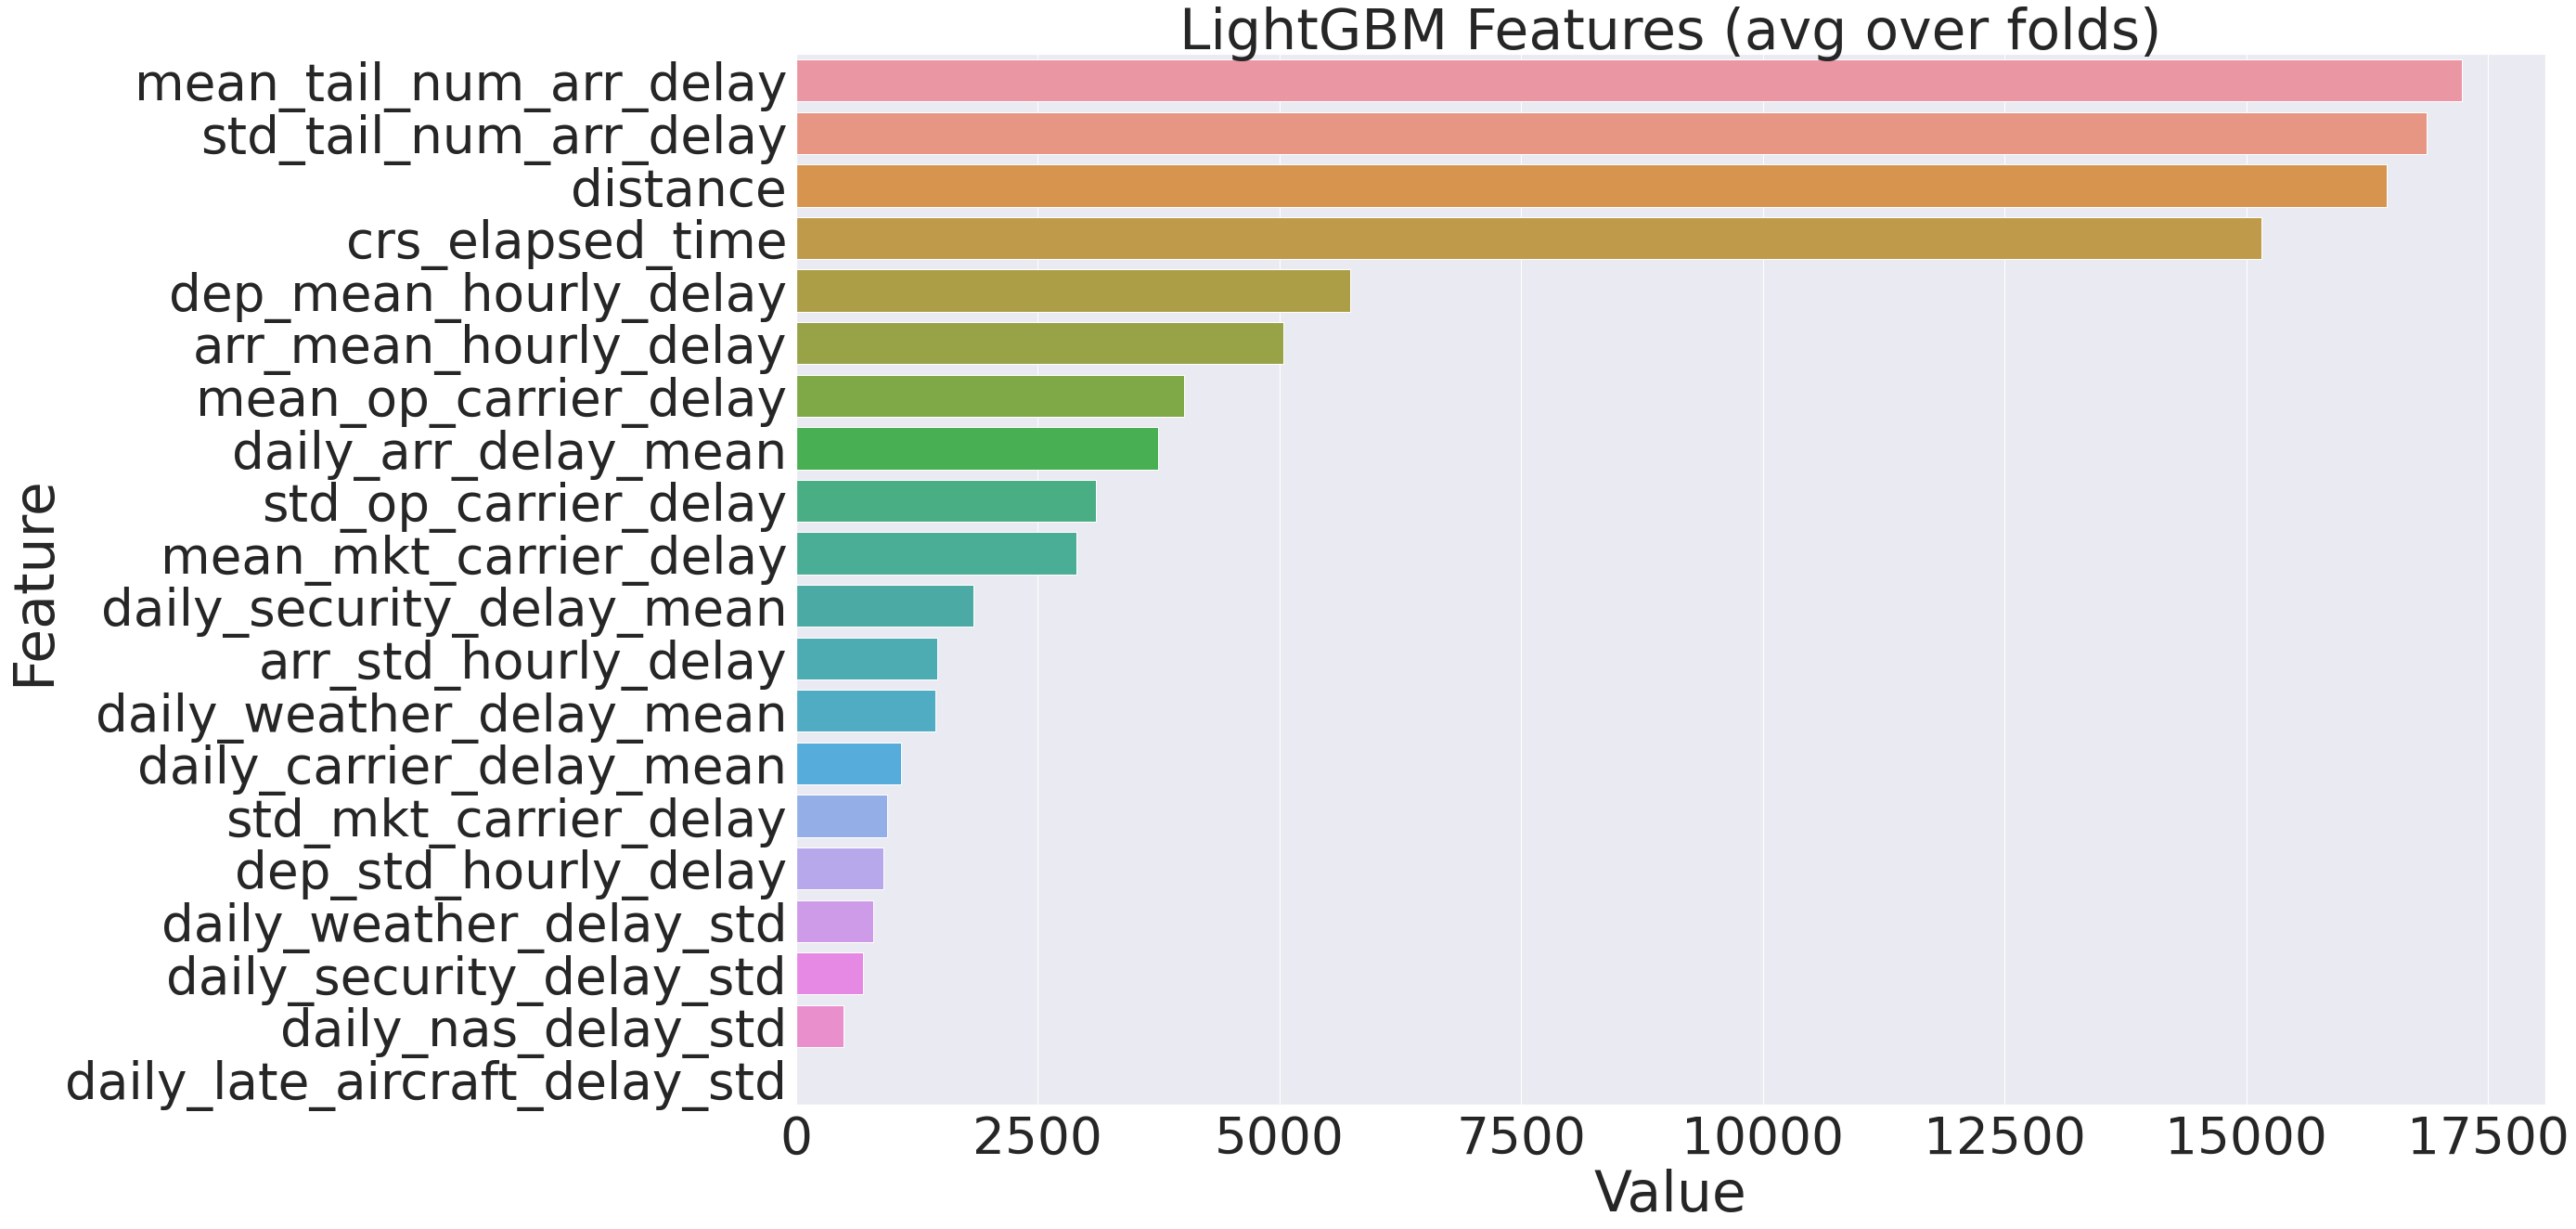

In [35]:
plotImp(clf_bst_GS_fitted, X_train_LGB_GS)

In [22]:
clf_bst_GS_fitted.best_estimator_.feature_importances_

array([14864, 16853,  3738,  1183,  1572,     0,  2031,     0,     0,
           0,   893,   509,   854,     0,  5643,  4880,   935,  1346,
        3112,  4111,   922,  3182, 16868, 16404])

In [ ]:
print('MSE:', metrics.mean_squared_error(y_test_LGB_GS, y_pred_LGB_GS))
print('RMSE:', metrics.mean_squared_error(y_test_LGB_GS, y_pred_LGB_GS)**0.5)
print('MAE:', metrics.mean_absolute_error(y_test_LGB_GS, y_pred_LGB_GS))

MSE: 878.0345574377205
RMSE: 29.631647902837273
MAE: 18.1737087177031


In [ ]:
### LightGB R2 score history:

# Default parameters, no categoricals, no scaling: 0.1919463732726694
# Default parameters, no categoricals, Minmax scaling: 0.18976732202768998
# Default parameters, no categoricals, Standard scaling: 0.18247798490057898

# Default parameters, with categoricals, no scaling: 0.27882229658630364
# Default parameters, with categoricals, MinMax scaling: 0.2587197794769981
# Default parameters, with categoricals, Standard scaling: 0.25394060985568734



# GridSearch, no categoricals, no scaling: 0.2569815579325422
# GridSearch, with categoricals, no scaling: 0.34436994397298737

# GridSearch, no categoricals, MinMax scaling: 0.2037215155495643
# Best GridSearch parameters: 'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 50

In [ ]:
# Use fitted model to predict Jan 2020 delays, and create sample_submission.csv
# Import from Google Drive
df_flights_test_final = pd.read_csv('/content/drive/My Drive/df_flights_test_final.csv')

In [ ]:
# Drop fl_date, mkt_carrier, and mkt_carrier_fl_num (these columns will only appear in sample_submission.csv)
df_flights_test_modelling = df_flights_test_final.drop(columns=['Unnamed: 0', 'fl_date', 'mkt_carrier', 'mkt_carrier_fl_num', 'origin', 'dest'])

# Preview dataframe data
df_flights_test_modelling.head(1)

,crs_elapsed_time,distance,daily_arr_delay_mean,daily_carrier_delay_mean,daily_weather_delay_mean,daily_nas_delay_mean,daily_security_delay_mean,daily_late_aircraft_delay_mean,daily_arr_delay_std,daily_carrier_delay_std,daily_weather_delay_std,daily_nas_delay_std,daily_security_delay_std,daily_late_aircraft_delay_std,dep_mean_hourly_delay,arr_mean_hourly_delay,dep_std_hourly_delay,arr_std_hourly_delay,mean_mkt_carrier_delay,mean_op_carrier_delay,std_mkt_carrier_delay,std_op_carrier_delay,mean_tail_num_arr_delay,std_tail_num_arr_delay
0,95,363,-7.601474,2.293873,0.208744,1.078996,0.002138,1.984977,28.767319,14.868113,5.377393,7.795824,0.20266,13.822821,14.600959,6.84241,38.198772,40.244274,4.035753,4.035753,15.809649,15.809649,-5.266667,14.273943


In [ ]:
y_pred_LGB_GS_flightstest = clf_bst_GS.predict(df_flights_test_modelling)
y_pred_LGB_GS_flightstest

array([ -1.94603851,  -4.74505641,   3.25173318, ...,   9.28830556,
         9.70779496, -19.83081923])

In [ ]:
sample_submission = df_flights_test_final.drop(columns='Unnamed: 0')

In [ ]:
sample_submission = pd.concat([sample_submission, pd.DataFrame(y_pred_LGB_GS_flightstest)], axis=1)

In [ ]:
sample_submission = sample_submission.drop(columns=['daily_arr_delay_mean',	'crs_elapsed_time', 'distance', 'daily_carrier_delay_mean', 'daily_weather_delay_mean',	'daily_nas_delay_mean',	'daily_security_delay_mean', 'daily_late_aircraft_delay_mean', 'daily_arr_delay_std', 'daily_carrier_delay_std', 'daily_weather_delay_std', 'daily_nas_delay_std', 'daily_security_delay_std', 'daily_late_aircraft_delay_std',	'dep_mean_hourly_delay', 'arr_mean_hourly_delay', 'dep_std_hourly_delay', 'arr_std_hourly_delay', 'mean_mkt_carrier_delay', 'mean_op_carrier_delay', 'std_mkt_carrier_delay', 'std_op_carrier_delay', 'mean_tail_num_arr_delay', 'std_tail_num_arr_delay'])

In [ ]:
sample_submission.rename(columns={0:'predicted_delay'},inplace=True)

In [ ]:
sample_submission['predicted_delay'].describe()

count    150623.000000
mean         -2.364385
std          13.914215
min         -46.352547
25%         -10.918300
50%          -5.297003
75%           2.420477
max         202.629710
Name: predicted_delay, dtype: float64

In [ ]:
sample_submission.head(1)

,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,predicted_delay
0,2020-01-01,WN,5888,ONT,SFO,-1.946039


In [ ]:
sample_submission.to_csv('sample_submission.csv')
!cp sample_submission.csv "drive/My Drive/"